<a href="https://colab.research.google.com/github/GhostXu11/Corona-Virus/blob/master/Project4_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import io

In [3]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_data.csv to covid_19_data.csv


In [13]:
covid = pd.read_csv(io.BytesIO(uploaded['covid_19_data.csv']))
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [14]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (14811, 8)
Checking for null values:
 SNo                   0
ObservationDate       0
Province/State     7286
Country/Region        0
Last Update           0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64
Checking Data-type of each column:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [0]:
covid.drop(["SNo"],1,inplace=True)

In [0]:
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])

In [19]:
#data summary
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])

Basic Information
Totol number of countries with Disease Spread:  220
Total number of Confirmed Cases around the World:  1917320.0
Total number of Recovered Cases around the World:  448655.0
Total number of Deaths Cases around the World:  119483.0
Total number of Active Cases around the World:  1349182.0
Total number of Closed Cases around the World:  568138.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]),
 <a list of 83 Text major ticklabel objects>)

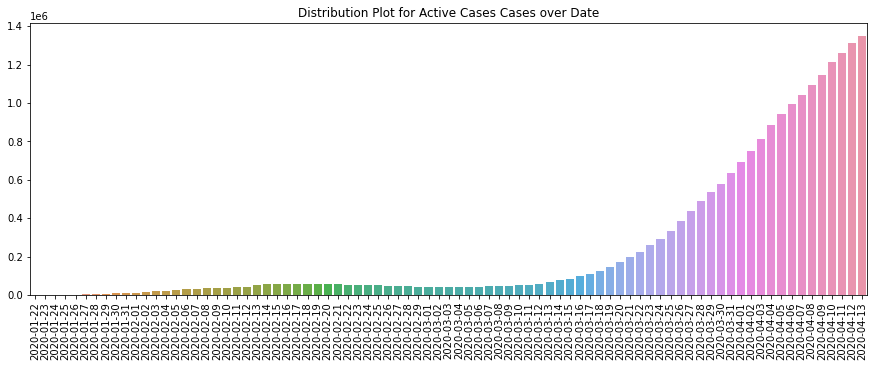

In [20]:
plt.figure(figsize=(15,5))
sns.barplot(x=datewise.index.date, y=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
plt.title("Distribution Plot for Active Cases Cases over Date")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]),
 <a list of 83 Text major ticklabel objects>)

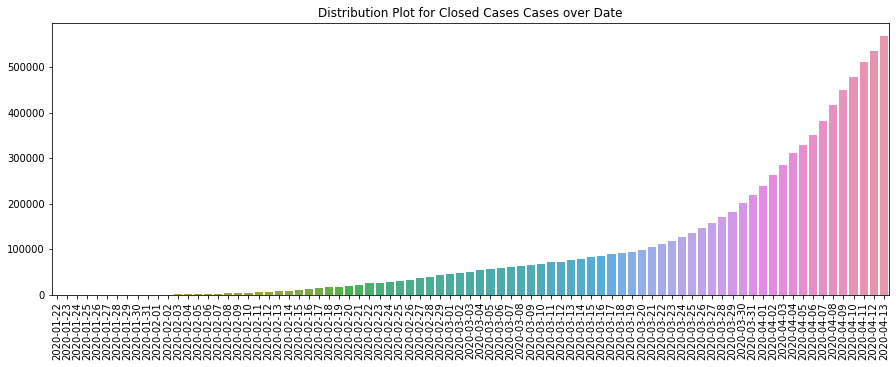

In [21]:
plt.figure(figsize=(15,5))
sns.barplot(x=datewise.index.date, y=datewise["Recovered"]+datewise["Deaths"])
plt.title("Distribution Plot for Closed Cases Cases over Date")
plt.xticks(rotation=90)

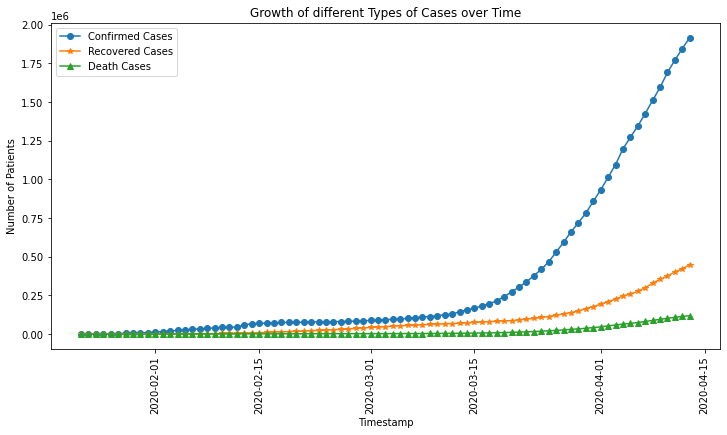

In [26]:
plt.figure(figsize=(12,6))
plt.plot(datewise["Confirmed"],marker="o",label="Confirmed Cases")
plt.plot(datewise["Recovered"],marker="*",label="Recovered Cases")
plt.plot(datewise["Deaths"],marker="^",label="Death Cases")
plt.ylabel("Number of Patients")
plt.xlabel("Timestamp")
plt.xticks(rotation=90)
plt.title("Growth of different Types of Cases over Time")
plt.legend()

In [0]:
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

Text(0.5, 1.0, 'Top 15 countries as  Number of Death Cases')

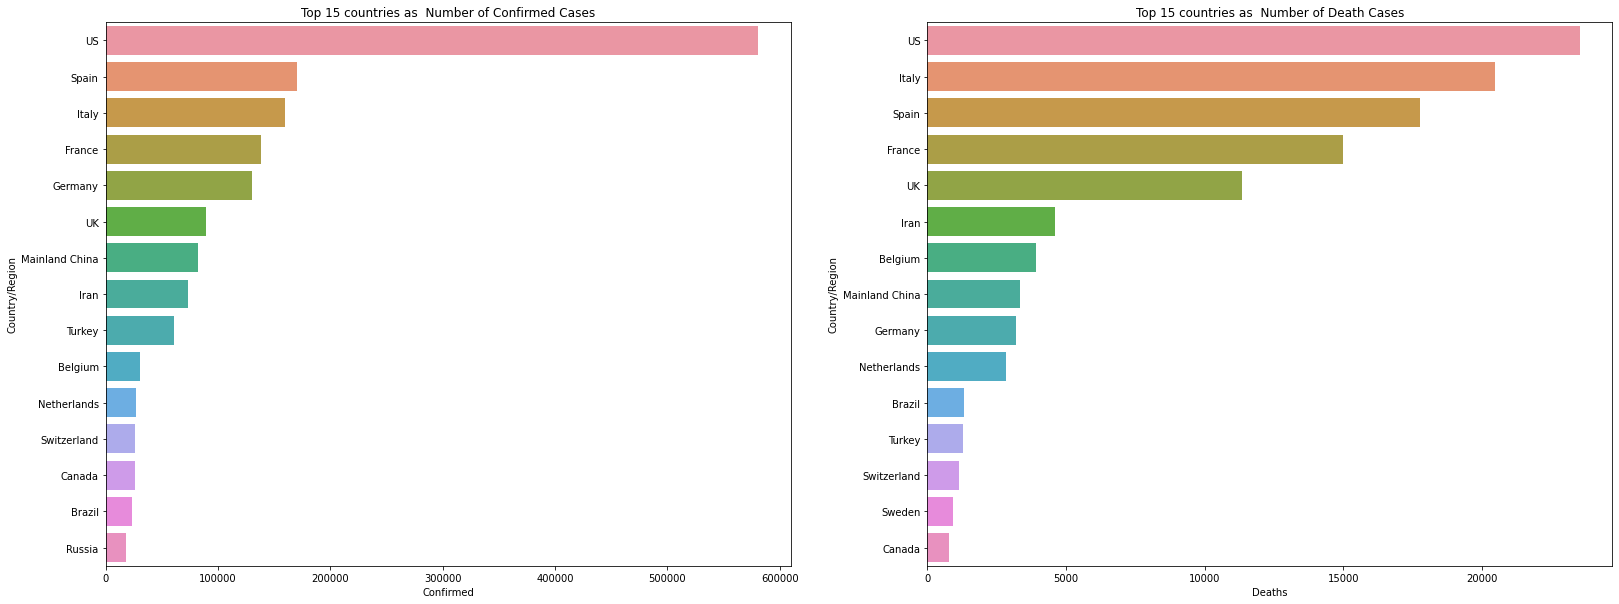

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(27,10))
top_15_confirmed=countrywise.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=countrywise.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 countries as  Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 countries as  Number of Death Cases")

In [0]:
#Part for ML
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [0]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.90)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.90):]
model_scores=[]

In [0]:
lin_reg=LinearRegression(normalize=True)

In [34]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [0]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [0]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

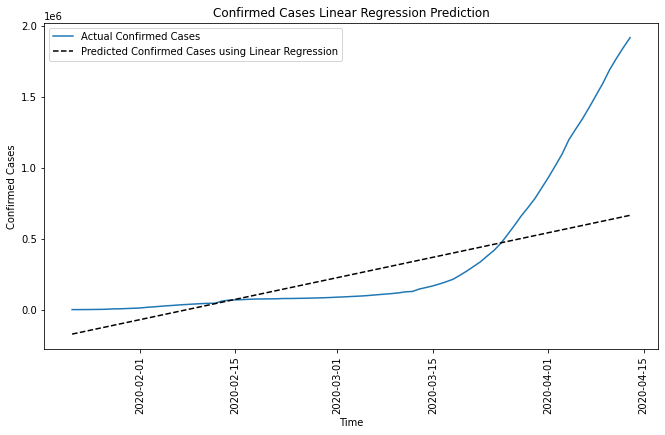

In [38]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Confirmed"],label="Actual Confirmed Cases")
plt.plot(datewise.index,prediction_linreg, linestyle='--',label="Predicted Confirmed Cases using Linear Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Linear Regression Prediction")
plt.xticks(rotation=90)
plt.legend()

In [0]:
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [40]:
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=6, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

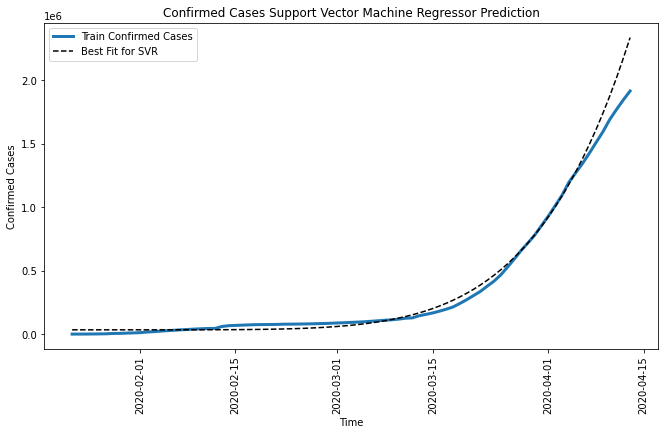

In [42]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Confirmed"],label="Train Confirmed Cases",linewidth=3)
plt.plot(datewise.index,prediction_svm, linestyle='--',label="Best Fit for SVR",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Support Vector Machine Regressor Prediction")
plt.xticks(rotation=90)
plt.legend()